In [1]:
import pandas as pd
import nltk
from nltk import TrigramAssocMeasures, BigramAssocMeasures
from nltk.collocations import *
from nltk.tokenize import RegexpTokenizer
from sklearn import feature_extraction
import re
import numpy as np

# Loads data 

In [6]:
reviewsdf = pd.read_csv("airportquality.csv", encoding = "utf8")
reviewsdf = reviewsdf[np.isfinite(reviewsdf['overall_rating'])]
reviewsdf.sample(10)

,airport_name,link,title,author,author_country,date,content,experience_airport,date_visit,type_traveller,overall_rating,queuing_rating,terminal_cleanliness_rating,terminal_seating_rating,terminal_signs_rating,food_beverages_rating,airport_shopping_rating,wifi_connectivity_rating,airport_staff_rating,recommended
613,amsterdam-schiphol-airport,/airport-reviews/amsterdam-schiphol-airport,Amsterdam Schiphol Airport customer review,D Hartono,Indonesia,2011-06-16,Its a good and spacious airport it also has a ...,NaN,NaN,NaN,4.0,5.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,0
11532,marsa-alam-airport,/airport-reviews/marsa-alam-airport,Marsa Alam Airport customer review,Paul Harvey,United Kingdom,2012-10-01,Despite the difficult situation in Egypt this ...,NaN,NaN,NaN,7.0,3.0,4.0,NaN,NaN,NaN,3.0,NaN,NaN,1
16761,toronto-pearson-airport,/airport-reviews/toronto-pearson-airport,Toronto Pearson Airport customer review,Don Romano,Canada,2011-08-01,The US Customs at Toronto Pearson Airport is r...,NaN,NaN,NaN,1.0,1.0,5.0,NaN,NaN,NaN,3.0,NaN,NaN,0
4079,dalaman-airport,/airport-reviews/dalaman-airport,Dalaman Airport customer review,T Nicholls,United Kingdom,2009-10-28,What an absolute disgrace! I got fleeced 40 li...,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,0
516,amsterdam-schiphol-airport,/airport-reviews/amsterdam-schiphol-airport,Amsterdam Schiphol Airport customer review,David Graham,United Kingdom,2014-04-24,I am aware that many reviewers are high in the...,NaN,NaN,NaN,2.0,3.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,0
13141,newcastle-airport,/airport-reviews/newcastle-airport,Newcastle Airport customer review,I Cameron,United Kingdom,2015-06-11,"What a disappointment, Newcastle Airport has g...",Arrival and Departure,NaN,Solo Leisure,4.0,5.0,5.0,2.0,NaN,2.0,2.0,NaN,NaN,1
12412,mumbai-airport,/airport-reviews/mumbai-airport,Mumbai Airport customer review,S Sankar,United Kingdom,2015-01-14,Flew on BA to London with young family on the ...,NaN,NaN,NaN,10.0,5.0,5.0,NaN,NaN,NaN,5.0,NaN,NaN,1
15912,southampton-airport,/airport-reviews/southampton-airport,Southampton Airport customer review,D McClelland,United Kingdom,2012-04-11,Disgusted with security at Southampton. After ...,NaN,NaN,NaN,1.0,2.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,0
16443,tel-aviv-airport,/airport-reviews/tel-aviv-airport,Tel Aviv Airport customer review,Kim Krister,Finland,2011-01-16,Departure procedures started 3 hours before fl...,NaN,NaN,NaN,3.0,1.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,0
9175,london-gatwick-airport,/airport-reviews/london-gatwick-airport,London Gatwick Airport customer review,P Holden,United Kingdom,2013-10-29,Gatwick Connect - promises much delivers not! ...,NaN,NaN,NaN,8.0,4.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,1


In [3]:
reviews = [row["content"] for index, row in reviewsdf.iterrows()]
ratings = [row["overall_rating"] for index, row in reviewsdf.iterrows()]
recommended = [row["recommended"] for index, row in reviewsdf.iterrows()]
print(ratings[0:10])

[9.0, 9.0, 9.0, 5.0, 4.0, 5.0, 4.0, 1.0, 2.0, 8.0]


#  Set up functions

## Stemming

In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

class Cleaner:
    def __init__(self, in_bigrams = [], in_trigrams= []):
        self.bigrams = in_bigrams
        self.trigrams = in_trigrams
        
    
    def stem_tokens(self, text):
        tokenizer = RegexpTokenizer(r'\w+')
        stopwords = nltk.corpus.stopwords.words('english')
        tokens = [word for word in tokenizer.tokenize(text.lower())]

        
        stemmed_tokens = [term for term in tokens if term not in stopwords]
        
        if len(self.bigrams) > 0:
            doc_bigrams = list(nltk.bigrams (stemmed_tokens))
            for term in doc_bigrams:
                if term in bigrams:
                    stemmed_tokens.append("_".join(term))
        
        if len(self.trigrams) > 0:
            doc_trigrams = list(nltk.trigrams (stemmed_tokens))
            for term in doc_trigrams:
                if term in trigrams:
                    stemmed_tokens.append("_".join(term))
        
        stemmed_tokens = [stemmer.stem(word) for word in stemmed_tokens 
                          if re.search('[a-zA-Z]', word)]
        
        return stemmed_tokens
clean = Cleaner()
print(clean.stem_tokens(reviews[1])[2:10])

['airport', 'moment', 'expand', 'airport', 'lot', 'build', 'go', 'departur']


## Finding ngram and prepare text

In [7]:

texts = [clean.stem_tokens(text) for text in reviews]

bigramfinder = BigramCollocationFinder.from_documents(texts)
bigramfinder.apply_freq_filter (30)
bigrams = bigramfinder.nbest(BigramAssocMeasures.likelihood_ratio,200)
bigrams = [(x,y) for x,y in bigrams if x!=y]
print(bigrams[0:5])
trigramfinder = TrigramCollocationFinder.from_documents(texts)
trigramfinder.apply_freq_filter (30)
trigrams = trigramfinder.nbest(TrigramAssocMeasures.likelihood_ratio,200)
trigrams = [(x,y,z) for x,y,z in trigrams if x!=y or x!=z or y!=z]
print(trigrams[0:5])

[('duti', 'free'), ('passport', 'control'), ('x', 'ray'), ('car', 'park'), ('baggag', 'claim')]
[('duti', 'free', 'shop'), ('duti', 'free', 'store'), ('duti', 'free', 'area'), ('duti', 'free', 'price'), ('shop', 'duti', 'free')]


In [8]:
text_cleaner =  Cleaner(bigrams, trigrams)

## Tfidf - Vectorizer

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define transformer 
tfidf = TfidfVectorizer(max_df=0.5, max_features=200000, 
                        min_df = 0.01, stop_words="english", 
                        use_idf = True, tokenizer=text_cleaner.stem_tokens)


In [10]:
tfidf_reviews = tfidf.fit_transform(reviews)

# Clustering

In [40]:
from sklearn.cluster import KMeans
number = 6
km = KMeans(n_clusters=number)
km.fit(tfidf_reviews)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [41]:
clusters = km.labels_.tolist()

In [47]:
ap_reviews = {'content':reviews, 'rating': ratings, 'cluster': clusters, 'recommended' : recommended}
frame = pd.DataFrame(ap_reviews, index = [clusters], 
                     columns=['content' , 'rating', 'cluster', 'recommended'])
frame['cluster'].value_counts()
frame = frame[np.isfinite(frame['rating'])]
groupByCluster = frame.groupby(frame['recommended'])

print(groupByCluster.mean())
bplot = groupByCluster.boxplot()
print(bplot)
#print(dir(groupByCluster))


               rating   cluster
recommended                    
0            2.858372  3.826281
1            7.844308  4.886166
0         Axes(0.1,0.15;0.363636x0.75)
1    Axes(0.536364,0.15;0.363636x0.75)
dtype: object


In [45]:
frame.to_csv('10_clusters.csv', index = False)

# KMeans Visualization

In [48]:
revMatrix = frame.as_matrix()
# a = dir(revMatrix) # show properties of matrix
# print(a)

For cluster visualization we use two parameters - overall rating (0-10) and recommended value (0-1). 
<li>X axis represents cluster number </li>
<li> Y axis represents avarage reccomended value in the cluster </li>
<li> Circle radius R represents normalized (0-1) average overall rating value in the cluster </li>

[4.4040902679830749, 3.4664466446644666, 3.0838709677419356, 4.060781476121563, 3.9168886521044222, 3.8765182186234819] 4.40409026798 3.08387096774


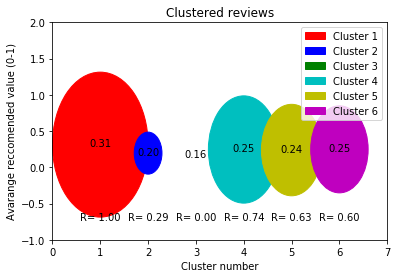

In [50]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Initial clusters

cluster0=[]
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]
cluster5=[]

#Asigning clusters to initial clusters
for i in range(0,revMatrix.shape[0]):
    if revMatrix[i,2] == 0:
        cluster0.append((revMatrix[i][1],revMatrix[i,3]))
    elif revMatrix[i,2] == 1:
        cluster1.append((revMatrix[i,1],revMatrix[i,3]))
    elif revMatrix[i,2] == 2:
        cluster2.append((revMatrix[i,1],revMatrix[i,3]))
    elif revMatrix[i,2] == 3:
        cluster3.append((revMatrix[i,1],revMatrix[i,3]))
    elif revMatrix[i,2] == 4:
        cluster4.append((revMatrix[i,1],revMatrix[i,3]))
    elif revMatrix[i,2] == 5:
        cluster5.append((revMatrix[i,1],revMatrix[i,3]))

#NP array conversion        
x0=np.array(cluster0)
x1=np.array(cluster1)
x2=np.array(cluster2)
x3=np.array(cluster3)
x4=np.array(cluster4)
x5=np.array(cluster5)

prep=[]

#Mean calculation
prep.append(x0[:,0].mean())
prep.append(x1[:,0].mean())
prep.append(x2[:,0].mean())
prep.append(x3[:,0].mean())
prep.append(x4[:,0].mean())
prep.append(x5[:,0].mean())

#Normalizing mean to 1..0 value
maxim = max(prep)
minim = min(prep)
print(prep,maxim,minim)
normalized=[]
for item in prep:
    normalized.append((item-minim) / (maxim-minim))
    
#Asigning mean to values
mean0 = x0[:,1].mean()
mean1 = x1[:,1].mean()
mean2 = x2[:,1].mean()
mean3 = x3[:,1].mean()
mean4 = x4[:,1].mean()
mean5 = x5[:,1].mean()


#Drawing circles
circle0 = plt.Circle((1, mean0),normalized[0], color='r')
circle1 = plt.Circle((2, mean1), normalized[1], color='b')
circle2 = plt.Circle((3, mean2), normalized[2], color='g')
circle3 = plt.Circle((4, mean3), normalized[3], color='c')
circle4 = plt.Circle((5, mean4), normalized[4], color='y')
circle5 = plt.Circle((6, mean5), normalized[5], color='m')



fig, ax = plt.subplots()

ax.add_artist(circle0)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
ax.add_artist(circle5)

ax.set_xlim((0, 7))
ax.set_ylim((-1, 2))


red_patch = mpatches.Patch(color='r', label='Cluster 1')
blue_patch = mpatches.Patch(color='b', label='Cluster 2')
g_patch = mpatches.Patch(color='g', label='Cluster 3')
c_patch = mpatches.Patch(color='c', label='Cluster 4')
y_patch = mpatches.Patch(color='y', label='Cluster 5')
m_patch = mpatches.Patch(color='m', label='Cluster 6')


#This part can be made nicer I guess. Printing and labeling part.

ax.legend(handles=[red_patch,blue_patch,g_patch,c_patch,y_patch,m_patch])
ax.text(1,mean0-0.05 , ("%.2f" % mean0) , ha='center', va='bottom')
ax.text(2,mean1-0.05 , ("%.2f" % mean1) , ha='center', va='bottom')
ax.text(3,mean2-0.05 , ("%.2f" % mean2) , ha='center', va='bottom')
ax.text(4,mean3-0.05 , ("%.2f" % mean3) , ha='center', va='bottom')
ax.text(5,mean4-0.05 , ("%.2f" % mean4) , ha='center', va='bottom')
ax.text(6,mean5-0.05 , ("%.2f" % mean5) , ha='center', va='bottom')

ax.text(1,-0.75 , ("R= %.2f" % normalized[0]) , ha='center', va='bottom')
ax.text(2,-0.75 , ("R= %.2f" % normalized[1]) , ha='center', va='bottom')
ax.text(3,-0.75 , ("R= %.2f" % normalized[2]) , ha='center', va='bottom')
ax.text(4,-0.75 , ("R= %.2f" % normalized[3]) , ha='center', va='bottom')
ax.text(5,-0.75 , ("R= %.2f" % normalized[4]) , ha='center', va='bottom')
ax.text(6,-0.75 , ("R= %.2f" % normalized[5]) , ha='center', va='bottom')


ax.set_title("Clustered reviews")
ax.set_xlabel("Cluster number")
ax.set_ylabel("Avarange reccomended value (0-1)")

plt.show()

In [ ]:
#explain very well in the report what it is visualizing.